In [38]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

import PolyolGasMethods as PGM

# user parameters
data_folder = '..\\DATA\\co2_p_in_parr\\'
file_string = '190307_*.txt'
# low and high values for counts on Arduino analog pin in current calibration
cts_lo = 207
cts_hi = 1023
# low and high values for pressures (psi) on pressure transducer
p_lo = 0
p_hi = 1500
# sublimation rate of dry ice [g/s]
subl_rate = 0.004
# volume of Parr reactor [mL]
V = 240

# CONVERSIONS
Pa2psi = 14.5E-5

In [39]:
def plot_p_vs_t(file_name, m, semilogx=False, x_lim=[]):
    """
    This function loads data for pressure vs. time in .csv format (pressure in first column,
    time in second) and plots.
    """
    # load data from file
    df = pd.read_csv(file_name)
    # parse data into pressure [units given] and time [seconds]
    p = df['p (psi)']
    t = df['t (s)']

    # PLOT
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if semilogx:
        ax.semilogx(t, p, 'o')
    else:
        ax.plot(t, p, 'o')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('pressure [psi]')
    ax.set_title('Pressure vs. Time with %.2f g Dry Ice' % m)
    if len(x_lim) == 2:
        ax.set_xlim(x_lim)
        
    return p, t

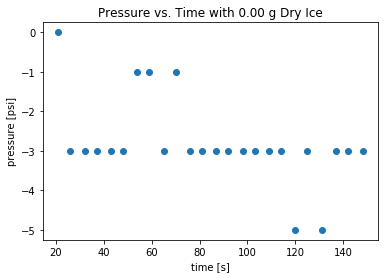

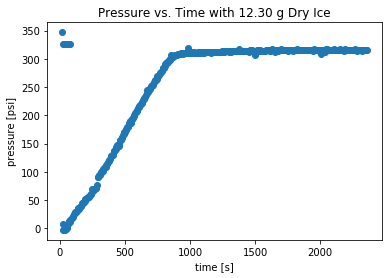

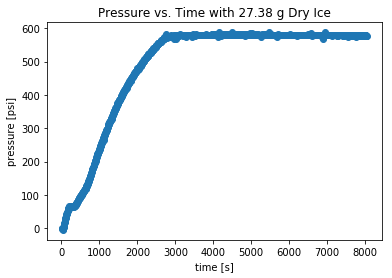

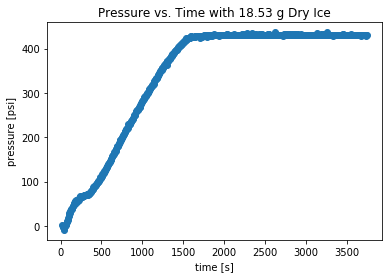

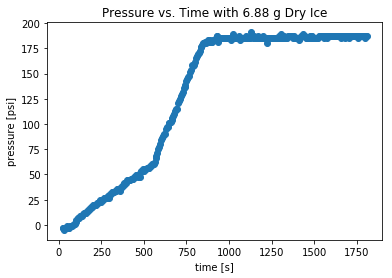

In [40]:
# load names of data files
file_list = glob.glob(data_folder + file_string)

# list of dry ice masses [g]
m_arr = np.array([0,12.32, 27.4, 18.55, 6.92])
# time at which dry ice was put in Parr reactor (immediately after weighing) [s]
t_in_parr = np.array([0, 35, 35, 42, 39])
# time to finger-tighten Parr reactor [s]
t_finger_tightened = np.array([0, 55, 60, 67, 75])
# corrected mass based on sublimation [g]
m_adj_arr = m_arr - subl_rate*(t_finger_tightened-t_in_parr)/4 # assume sublimation is 4 times slower in Parr than in open air

# initialize array to store final pressures
p_f_arr = np.zeros([len(m_adj_arr)])
# initialize array to store eos pressure
p_eos_arr = np.zeros([len(m_adj_arr)])

# plot data and store final and EoS-predicted pressures
for trial in range(len(file_list)):
    # extract values for current trial
    m = m_adj_arr[trial]
    file = file_list[trial]
    # plot
    p, t = plot_p_vs_t(file, m)
    
    # take average of last 10 readings to get final pressure (psi)
    p_f_arr[trial] = np.mean(p[-20:])
    # average density of CO2 in Parr reactor [g/mL]
    rho_co2 = m / V
    # compute pressure based on EoS [psi]
    p_eos_arr[trial] = Pa2psi*PGM.interpolate_eos_co2('p', value=rho_co2)   

Now analyze the EoS and measured pressures to adjust the calibration of the Arduino.

In [41]:
p_f_arr = np.concatenate((p_f_arr, np.array([694.8])))
p_eos_arr = np.concatenate((p_eos_arr, np.array([812-0.004/2*50])))

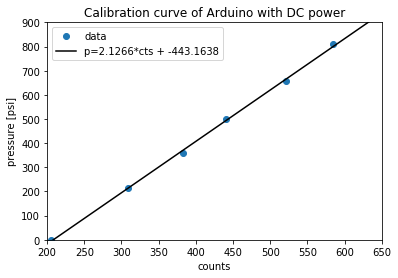

In [42]:
# compute counts measured by Arduino with previous calibration
cts_arr = (cts_hi-cts_lo)*(p_f_arr-p_lo)/(p_hi-p_lo) + cts_lo

# linear fit
slope, intercept = np.polyfit(cts_arr, p_eos_arr, 1)
cts_fit = np.linspace(cts_lo, cts_hi, 20)
p_fit = slope*cts_fit + intercept

# plot linear fit to verify
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(cts_arr, p_eos_arr, 'o', label="data")
ax.plot(cts_fit, p_fit, 'k-', label="p=%.4f*cts + %.4f" %(slope, intercept))
ax.set_xlabel("counts")
ax.set_ylabel("pressure [psi]")
ax.set_title("Calibration curve of Arduino with DC power")
ax.set_xlim([200,650])
ax.set_ylim([0,900])
plt.legend(loc="best")

In [43]:
cts_lo_new = -intercept/slope
cts_hi_new = (p_hi-intercept)/slope

print("New count value for low pressure (p=%d) = %d" % (p_lo,round(cts_lo_new)))
print("New count value for high pressure (p=%d psi) = %d" % (p_hi,round(cts_hi_new)))

New count value for low pressure (p=0) = 208
New count value for high pressure (p=1500 psi) = 914


In [44]:
slope_p = (cts_hi-cts_lo)/(cts_hi_new-cts_lo_new)
intercept_p = p_hi*(cts_lo-cts_lo_new)/(cts_hi_new-cts_lo_new) 

p_new = slope_p*p_f_arr + intercept_p
print(p_f_arr)
print(p_eos_arr)
print(p_new)

[ -2.9  322.95 578.3  430.25 186.7  694.8 ]
[  0.         358.09567421 656.40167073 499.17994824 213.48225344
 811.9       ]
[ -6.31204894 370.6546133  666.06181663 494.7869529  213.03083632
 800.8373764 ]


In [45]:
slope

2.1266024957497343

In [33]:
intercept_p

-2.9332390437857243